In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cnmfsns as cn
cn.start_logging()

## Working with `Dataset` objects

Datasets can be created from pandas DataFrames quite easily.

In [3]:
import pandas as pd

data = pd.read_table("diamandis_data/diamandis_nobulk.txt", index_col=0)  # normalized expression data
metadata = pd.read_table("diamandis_data/diamandis_nobulk.metadata.txt", index_col=0)  # sample metadata

# create dataset from DataFrames
diamandis = cn.Dataset.from_df(data=data, obs=metadata, is_normalized=True, patient_id_col="patient_id")

They can be written to and read from AnnData files (h5ad format).

In [4]:
diamandis.write_h5ad("diamandis.h5ad")  # write to .h5ad file
diamandis = cn.Dataset.from_h5ad("diamandis.h5ad")  # read a .h5ad file

2023-03-07 11:23:12,900 [INFO] Writing to /home/tbverhey/github/cNMF-SNS/example/diamandis.h5ad
2023-03-07 11:23:12,927 [INFO] Done


`Dataset` objects contain an AnnData object which can also be used for interfacing with other tools

In [5]:
diamandis.adata

AnnData object with n_obs × n_vars = 77 × 3560
    obs: 'patient_id', 'simple_category', 'detailed_category', 'age', 'sex', 'location of resection', 'ATRX', 'p53', 'MGMT'
    uns: 'cnmfsns_version', 'history', 'is_normalized', 'odg'

cNMF-SNS can recognize and import AnnData .h5ad files whether they are created in [Seurat](https://satijalab.org/seurat/archive/v2.4/conversion_vignette.html), [scanpy](https://scanpy.readthedocs.io/en/stable/usage-principles.html#anndata), or other single-cell software tools.

In [6]:
import scanpy

pbmc_adata = scanpy.datasets.pbmc3k()
pbmc_dataset = cn.Dataset.from_anndata(pbmc_adata)

  0%|          | 0.00/5.58M [00:00<?, ?B/s]

## Modelling mean and dispersion of genes

In [7]:
diamandis.compute_gene_stats()
diamandis.adata.var.head()  # results are stored in dataset object

,mean,rank_mean,variance,sd,missingness,log_mean,log_variance,mean_counts,odscore_excluded,resid_log_variance,odscore,gam_fittedvalues,vscore
A1BG,1.839333e+07,2152.0,1.787097e+14,1.336824e+07,0.0,7.264660,14.252150,1.839333e+07,False,0.090640,1.109992,14.161510,1.621348
A2M,2.338366e+08,3351.0,2.278611e+16,1.509507e+08,0.0,8.368914,16.357672,2.338366e+08,False,0.040063,1.047204,16.317609,4.806647
AAAS,2.478940e+06,203.0,9.438756e+11,9.715326e+05,0.0,6.394266,11.974916,2.478940e+06,False,-0.186994,0.806312,12.161910,0.077113
AAK1,1.713328e+07,2096.0,2.520759e+14,1.587690e+07,0.0,7.233840,14.401531,1.713328e+07,False,0.294975,1.404389,14.106556,2.489859
AARS1,1.069756e+08,3146.0,9.684865e+14,3.112052e+07,0.0,8.029285,14.986094,1.069756e+08,False,-0.652043,0.472040,15.638137,0.763087


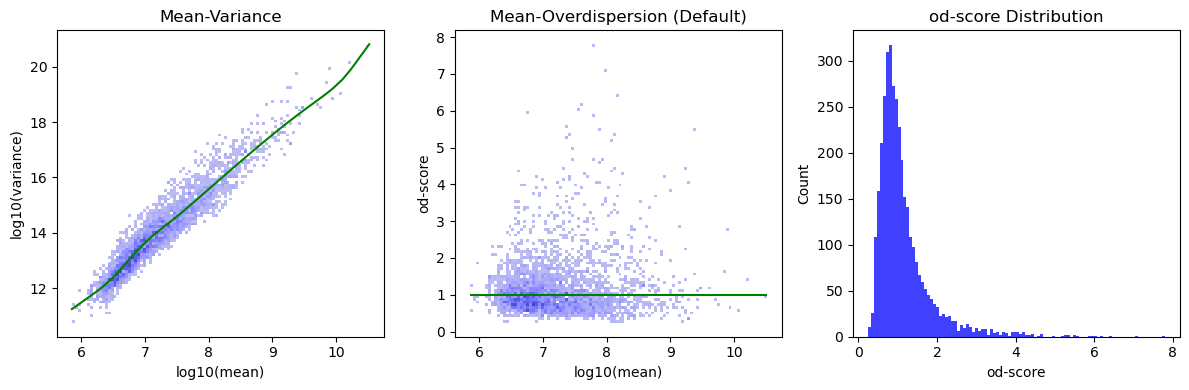

In [8]:
figs = cn.plot_feature_dispersion(diamandis, show_selected=False)

## Selecting overdispersed genes

2023-03-07 11:23:18,021 [INFO] 1612 genes selected for factorization


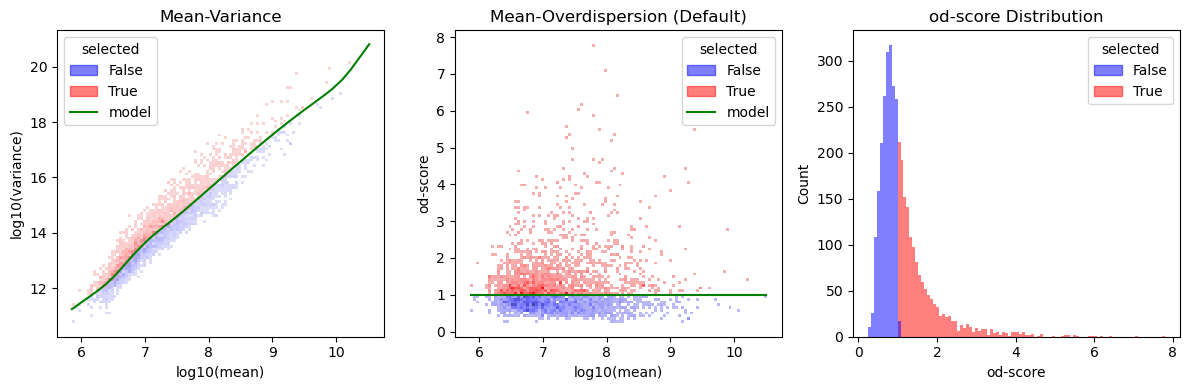

In [9]:
diamandis.select_overdispersed_genes()
figs = cn.plot_feature_dispersion(diamandis, show_selected=True)

Default parameters for `select_overdispersed_genes()` results in about 50% of genes as being overdispersed:

In [10]:
diamandis.adata.var["selected"].value_counts()

False    1948
True     1612
Name: selected, dtype: int64

## Factorization

In [11]:
cnmf_results_dir = "cnmf_results"
run_name = "diamandis"
# by default, k=2-60 is run with n_iter=200. For this demo, we will speed it up by drastically subsetting.
kvals = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
kvals = [2, 3 ,4, 5, 6, 7, 8]
n_iter = 10

cnmf_run = diamandis.initialize_cnmf(output_dir=cnmf_results_dir, name=run_name, kvals=kvals, n_iter=n_iter)

cnmf_run.factorize(verbose=False)
cnmf_run.postprocess()

# Merges cNMF results into the `Dataset` object
diamandis.add_cnmf_results(cnmf_output_dir=cnmf_results_dir, cnmf_name=run_name)
diamandis.write_h5ad("diamandis.h5ad")  # overwrite original file

2023-03-07 11:23:23,775 [INFO] Factorization outputs (individual iterations) were found for all values of k. No missing files were detected.
2023-03-07 11:23:23,776 [INFO] Merging iterations for k=2
2023-03-07 11:23:23,779 [INFO] Combining factorizations for k=2.
2023-03-07 11:23:23,811 [INFO] Merging iterations for k=3
2023-03-07 11:23:23,813 [INFO] Combining factorizations for k=3.
2023-03-07 11:23:23,850 [INFO] Merging iterations for k=4
2023-03-07 11:23:23,853 [INFO] Combining factorizations for k=4.
2023-03-07 11:23:23,890 [INFO] Merging iterations for k=5
2023-03-07 11:23:23,892 [INFO] Combining factorizations for k=5.
2023-03-07 11:23:23,935 [INFO] Merging iterations for k=6
2023-03-07 11:23:23,938 [INFO] Combining factorizations for k=6.
2023-03-07 11:23:23,983 [INFO] Merging iterations for k=7
2023-03-07 11:23:23,986 [INFO] Combining factorizations for k=7.
2023-03-07 11:23:24,030 [INFO] Merging iterations for k=8
2023-03-07 11:23:24,032 [INFO] Combining factorizations for k=8

## Stability-Error Plot

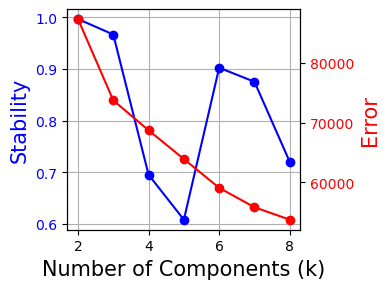

In [12]:
fig = cn.plot_stability_error(diamandis, figsize=[4,3])

fig.savefig("stability-error.pdf")  # Save figures in PDF or PNG format

## Plot GEP usage

In [13]:
diamandis.get_usages()

2                      3                          \
                   1          2           1           2           3   
sample_1   286422.00  67904.516  275513.200  52312.3200   35437.312   
sample_10  275476.38  43005.310  224016.920  31206.4260   66867.060   
sample_11  304163.75  46965.246  314410.220  32612.0160   16981.146   
sample_12  325379.60  25240.705  351193.800  10192.8680    5713.514   
sample_13  322658.30  10211.068  272968.660   3209.6064   62763.492   
...              ...        ...         ...         ...         ...   
sample_75  381448.88   4474.345   18181.727   2149.2761  332737.750   
sample_76  340807.90   7864.059   69725.700   4248.8447  252352.120   
sample_77  375968.60   5517.057   33970.460   3790.2468  313321.120   
sample_8   296149.72  25802.525  304186.400  12325.6170   18312.720   
sample_9   353327.38  24052.037  359148.560  11834.8810   21008.438   

                    4                                                  5  ...  \
                    1           2            3            4            1  ...   
sample_1   217699.900  36189.8550   26286.6540   91024.3750  189635.2700  ...   
sample_10  172470.190  18646.6170   57457.2970   83339.6700   87933.6800  ...   
sample_11  293712.940  29431.3830   11185.1060   13423.4800   49595.5200  ...   
sample_12  330632.800   9119.5310    2247.8630    6226.9043  285256.7800  ...   
sample_13  247564.550   1269.7290   56023.6760   25729.1100  104098.4700  ...   
...               ...         ...          ...          ...          ...  ...   
sample_75   21549.469   1267.5083  326507.7000    3788.2078   12546.5300  ...   
sample_76   63915.605   1858.8100  243239.3600   18822.8930   24502.9410  ...   
sample_77   38332.555   2325.8762  303834.8800    6823.1430   12063.1045  ...   
sample_8   208099.330   1085.4712    7735.2803  138610.2300  165195.7500  ...   
sample_9   340635.400  10890.9795   15049.4770    6032.2940   79060.8800  ...   

                     7                         8                            \
                     6           7             1            2            3   
sample_1    50462.7420   6488.8477  32669.143000   50066.8320  201374.4400   
sample_10   19306.4980   1583.6549  13874.015000   42747.6950  155958.5000   
sample_11   25317.3000   6180.1504  26595.783000  213816.6100   20029.2560   
sample_12  253854.7300   3126.1685   2797.242700   56244.1050   12238.0160   
sample_13   26452.8050   1950.2677    575.573700  138592.8600   82991.5550   
...                ...         ...           ...          ...          ...   
sample_75    4767.4985   1616.2211   1275.022100   21327.1540    6824.0970   
sample_76    6603.2344    915.0027   1177.653200   37611.8480   55881.6560   
sample_77    6358.0054   1455.9498     15.684195    3815.1677     847.2904   
sample_8    26190.7830  13315.0510   1305.021100   64709.5430  239602.1200   
sample_9    69599.6200   3296.5227   8829.542000  246564.7000   17114.0640   

                                                                           
                    4            5            6             7           8  
sample_1   41140.8500   10573.0880   47783.7730   10842.81200  4287.09300  
sample_10  10267.0780   17655.5620   14251.4375   95007.65000  1431.21040  
sample_11  17193.0720    8274.9710   24022.6720   27331.85000  4490.33500  
sample_12  13005.5300     891.9076  255024.7000     135.54317  2155.03250  
sample_13  39861.5600   45101.8500   25701.3360    6803.32700  1102.97450  
...               ...          ...          ...           ...         ...  
sample_75  25258.1480  293068.7000    4870.3374    2553.07640  1362.13200  
sample_76   4969.9517  215206.6000    5950.1290   18787.75000   658.89890  
sample_77   3449.1920  226536.5300     719.1783  117068.99000   277.91678  
sample_8   44744.4600     687.1954   22454.8090     229.95465  8677.76800  
sample_9    8837.0640   14646.7680   69242.4400     397.26230  1789.89720  

[77 rows x 35 columns]

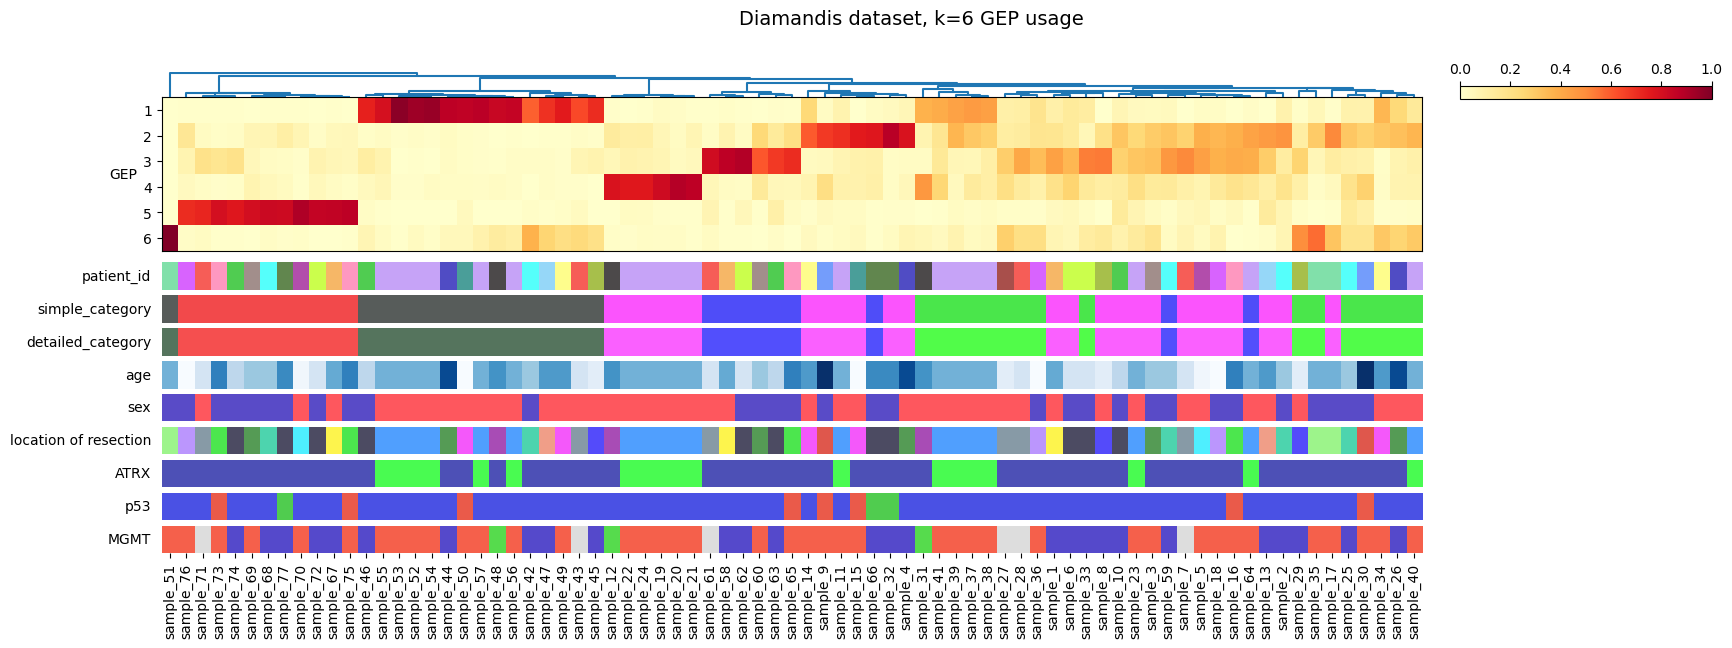

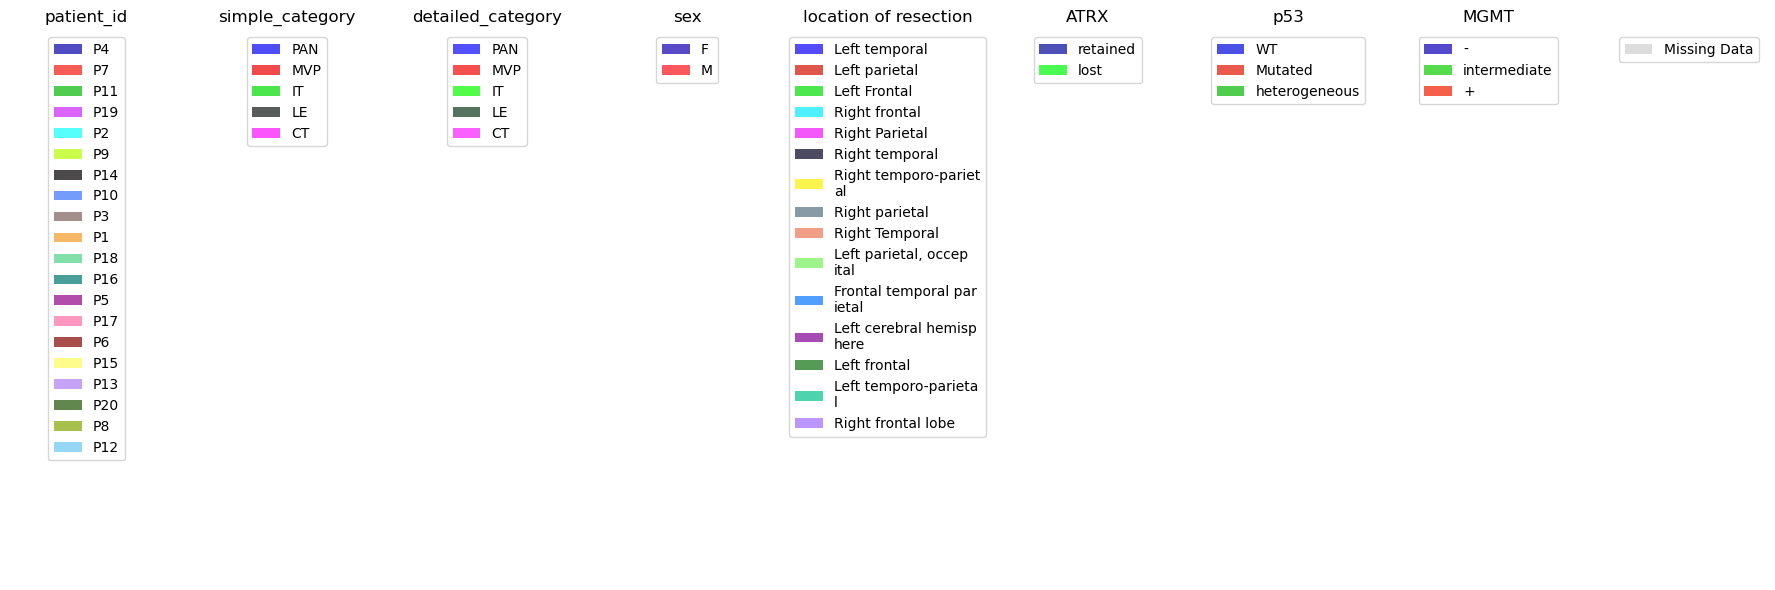

In [15]:
colors = cn.Colors.from_dataset(diamandis, pastel_factor=0.4)  # create distinct colors for metadata tracks


fig = cn.plot_usage_heatmap(diamandis, k=6, colors=colors,
                                     title="Diamandis dataset, k=6 GEP usage")
fig.savefig("k6_usages_heatmap.pdf")

fig_legend = colors.plot_metadata_colors_legend()
fig.savefig("diamandis_metadata_colors_legend.pdf")

## Factorize a second dataset for integration

In [16]:
data = pd.read_csv("cptac_data/cptac_gbm.csv", index_col=0).T  # normalized expression data
metadata = pd.read_table("cptac_data/cptac_gbm.metadata.txt", index_col=0)  # sample metadata

# create dataset from CPTAC example data
cptac = cn.Dataset.from_df(data=data, obs=metadata, is_normalized=True, patient_id_col = "patient_id")
cptac.compute_gene_stats()
cptac.select_overdispersed_genes()

# creates directory with cNMF results
cnmf_results_dir = "cnmf_results"
run_name = "cptac"
cnmf_run = cptac.initialize_cnmf(output_dir=cnmf_results_dir, name=run_name, kvals=kvals, n_iter=n_iter)
cnmf_run.factorize(verbose=False)
cnmf_run.postprocess()

# Merges cNMF results into the `Dataset` object
cptac.add_cnmf_results(cnmf_output_dir=cnmf_results_dir, cnmf_name=run_name)
cptac.write_h5ad("cptac.h5ad")  # write to h5ad file

2023-03-07 11:27:18,347 [INFO] 4554 genes selected for factorization
2023-03-07 11:29:18,810 [INFO] Factorization outputs (individual iterations) were found for all values of k. No missing files were detected.
2023-03-07 11:29:18,815 [INFO] Merging iterations for k=2
2023-03-07 11:29:18,821 [INFO] Combining factorizations for k=2.
2023-03-07 11:29:18,957 [INFO] Merging iterations for k=3
2023-03-07 11:29:18,961 [INFO] Combining factorizations for k=3.
2023-03-07 11:29:19,081 [INFO] Merging iterations for k=4
2023-03-07 11:29:19,085 [INFO] Combining factorizations for k=4.
2023-03-07 11:29:19,193 [INFO] Merging iterations for k=5
2023-03-07 11:29:19,197 [INFO] Combining factorizations for k=5.
2023-03-07 11:29:19,307 [INFO] Merging iterations for k=6
2023-03-07 11:29:19,310 [INFO] Combining factorizations for k=6.
2023-03-07 11:29:19,424 [INFO] Merging iterations for k=7
2023-03-07 11:29:19,427 [INFO] Combining factorizations for k=7.
2023-03-07 11:29:19,544 [INFO] Merging iterations fo

# TODO: Why is this necessary?

In [17]:
cptac.patient_id_col = "patient_id"
diamandis.patient_id_col = "patient_id"

## Integrate multiple datasets together

In [18]:
datasets = {"CPTAC": cptac,
            "Diamandis": diamandis}
integration = cn.Integration(datasets=datasets)  # create an integration object
colors = cn.Colors.from_integration(integration)  # create color scheme for metadata and datasets
colors.to_toml("colors.toml")  # save to file for reference (TOML file can be re-imported)

2023-03-07 11:29:53,894 [INFO] nancorrmp found. Calculating Pearson correlation matrix using 16 CPUs.
2023-03-07 11:29:54,316 [INFO] Choosing distinct dataset colors
2023-03-07 11:29:54,336 [INFO] Choosing distinct colors for metadata layer patient_id
2023-03-07 11:29:58,725 [INFO] Choosing distinct colors for metadata layer simple_category
2023-03-07 11:29:58,736 [INFO] Choosing distinct colors for metadata layer detailed_category
2023-03-07 11:29:58,748 [INFO] Choosing distinct colors for metadata layer multiomic
2023-03-07 11:29:58,762 [INFO] Choosing distinct colors for metadata layer r_wang_cancer_cell_2017
2023-03-07 11:29:58,777 [INFO] Choosing distinct colors for metadata layer d_methyl
2023-03-07 11:29:58,808 [INFO] Choosing distinct colors for metadata layer d_methyl_mnp
2023-03-07 11:29:58,860 [INFO] Choosing distinct colors for metadata layer is_gcimp
2023-03-07 11:29:58,868 [INFO] Choosing distinct colors for metadata layer immune
2023-03-07 11:29:58,884 [INFO] Choosing di

Identify gene overlap between datasets

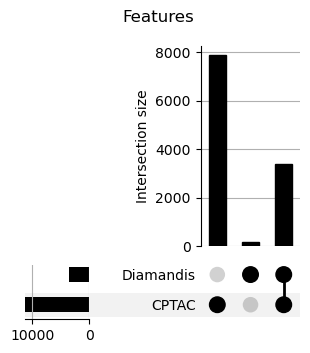

In [19]:
cn.plot_features_upset(integration)

A subset of these are identified as overdispersed in each dataset, and there is a significant overlap between datasets, indicating similar variation is seen in the two separate datasets.

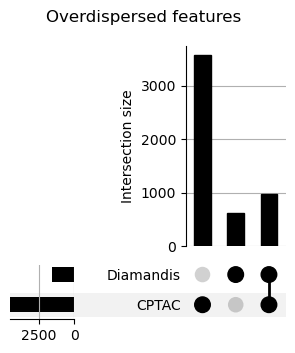

In [20]:
cn.plot_overdispersed_features_upset(integration)

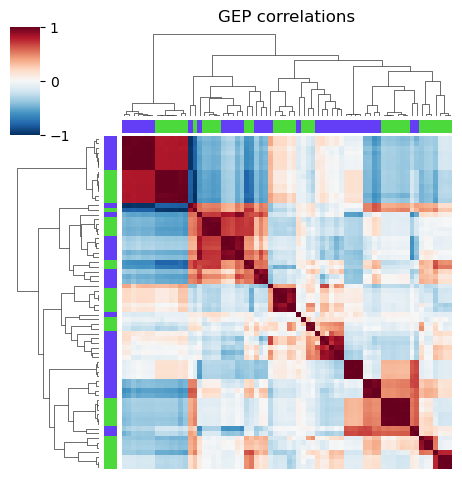

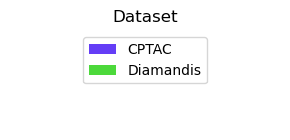

In [21]:
# plot the correlation matrix of all GEPs to each other
fig = cn.plot_gep_correlation_matrix(integration, colors=colors, figsize=[6, 6], hide_gep_labels=True)
fig.savefig("correlation_matrix.pdf")

# plot the legend separately as it applies to multiple figures
figlegend = colors.plot_dataset_colors_legend()
figlegend.savefig("datasets_legend.pdf")

To see if the `max_median_corr` threshold removed any ranks from either of the datasets, the following plot can be generated. The x-axis is the max-k, a threshold that excludes ranks above. The y-axis is the median of the correlation coefficients for all non-self edges in the correlation network. As this this threshold is slowly increased, the number of ranks, and thus nodes, and thus edges increases. The correlation between all edges slowly increases. In some datasets, this median of correlations will exceed 0 at high ranks. These high ranks will be excluded by this filter.

You can easily see for each rank whether there is a cNMF result, the stability/error of the result, as well as whether the ranks will be excluded on the basis of a max-k filter (derived from the max_median_corr parameter). You can also see which ranks will be selected (selected_k) based on automatic node subsetting for the final SNS maps.

In [22]:
integration.k_table

CPTAC                                                                  \
  cNMF result max_k_filter_pass max_k_median_corr prediction_error selected_k   
2        True              True         -0.991623    297249.843750       True   
3        True              True         -0.422671    271582.093750       True   
4        True              True         -0.341154    254937.531250       True   
5        True              True         -0.201273    241561.843750       True   
6        True              True         -0.159251    231833.312500       True   
7        True              True         -0.158835    227103.234375       True   
8        True              True         -0.132421    220836.750000       True   

              Diamandis                                                       \
  stability cNMF result max_k_filter_pass max_k_median_corr prediction_error   
2  0.993513        True              True         -0.999229     87352.593750   
3  0.904137        True              True         -0.437493     73715.671875   
4  0.829815        True              True         -0.199420     68699.164062   
5  0.710595        True              True         -0.152191     63882.812500   
6  0.631693        True              True         -0.134313     59046.832031   
7  0.502440        True              True         -0.118690     55801.218750   
8  0.469991        True              True         -0.106101     53712.945312   

                        
  selected_k stability  
2       True  0.996522  
3       True  0.966540  
4       True  0.695141  
5       True  0.608236  
6       True  0.902309  
7       True  0.875062  
8       True  0.720082

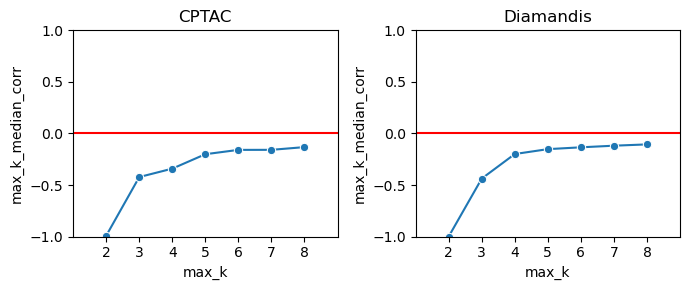

In [23]:
fig = cn.plot_rank_reduction(integration)

You can see that no k-values exceeded the threshold, so no max_k filter was applied. Now, let's plot the distribution of correlations for GEPs within and between datasets. This will show the min_corr thresholds. There is one threshold per dataset pair, and one threshold for within each dataset.

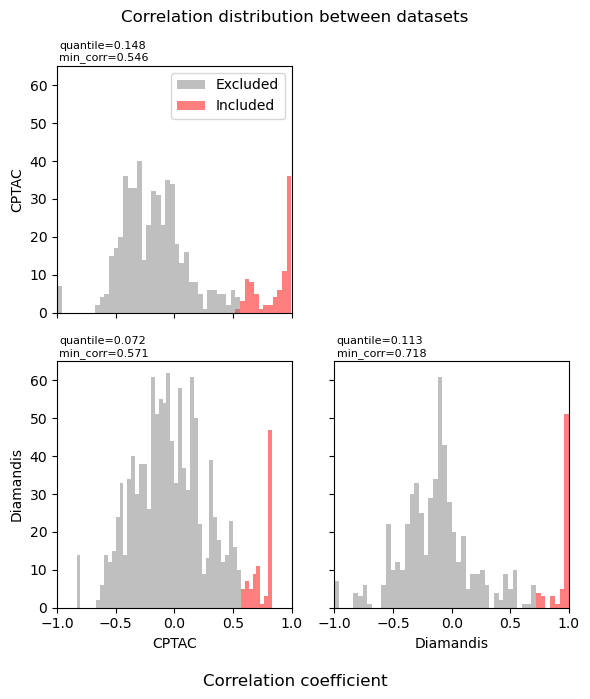

In [24]:
fig = cn.plot_pairwise_corr(integration)
# fig2 = cn.plot_pairwise_corr_overlaid(integration)  # overlaid plots show the mirrored distributions

See the number of nodes from each dataset with and without the node filters (including maxk and selectedk filters) and the edge filter (min_corr thresholds).

In [25]:
integration.get_node_table()

Node filter none         maxk         selectedk        
Edge Filter none mincorr none mincorr      none mincorr
CPTAC         35      35   35      35        35      35
Diamandis     35      35   35      35        35      35

## Create an SNS integration

2023-03-07 11:30:02,889 [INFO] Community search: algorithm = greedy_modularity, resolution = 1
2023-03-07 11:30:02,941 [INFO] Creating community network


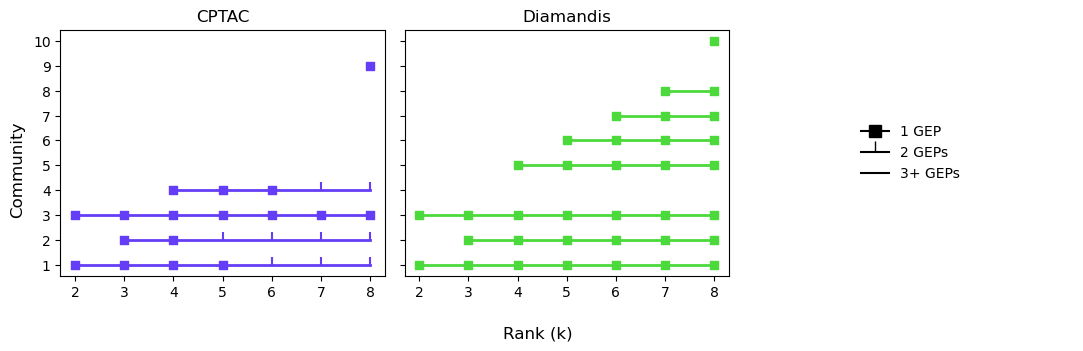

In [26]:
snsmap = cn.SNS(integration)
snsmap.community_search(algorithm="greedy_modularity", resolution=1)
fig = cn.plot_community_by_dataset_rank(snsmap, colors)

# Plot an SNS Map

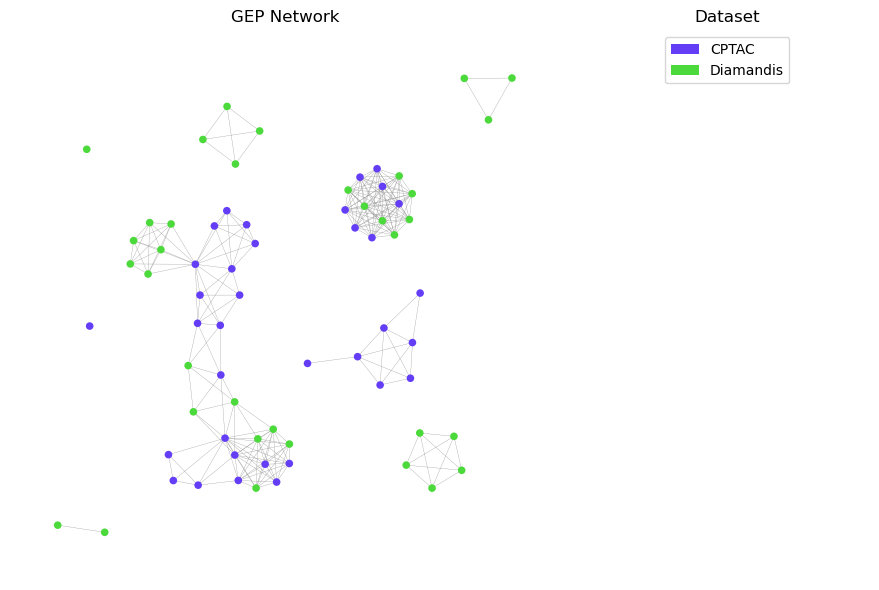

In [27]:
import cnmfsns as cn
snsmap.compute_layout(algorithm="neato")
fig = cn.plot_gep_network_datasets(snsmap, colors, node_size_kval=False)

How many samples have each GEP/node as their highest usage GEP? 

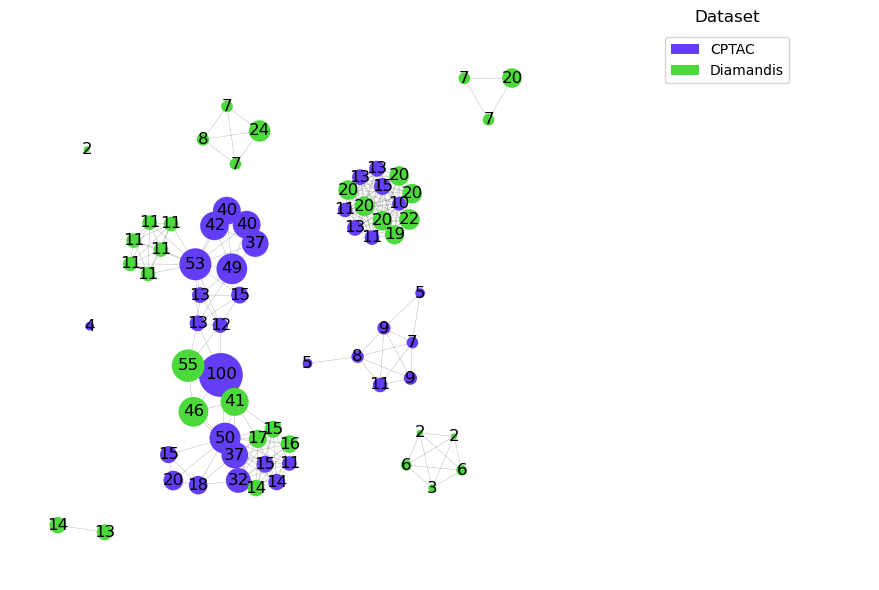

In [28]:
fig = cn.plot_gep_network_samples(snsmap,
                                  colors,
                                  node_size=1e3,
                                  font_size=12,
                                  discretize=True)

How many patients is each GEP primarily associated to?

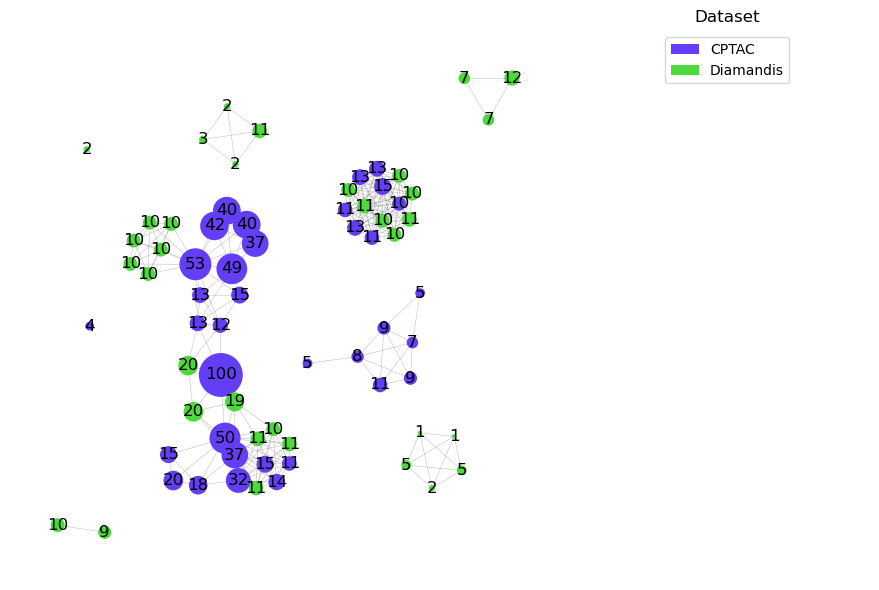

In [29]:
fig = cn.plots.plot_gep_network_patients(snsmap,
                                         colors,
                                         node_size=1e3,
                                         font_size=12)


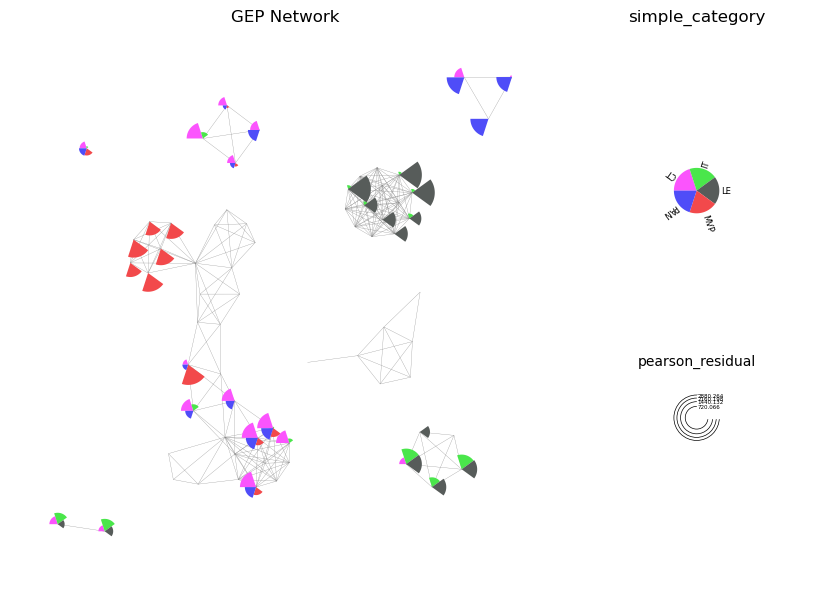

In [30]:
fig = cn.plot_gep_overrepresentation_network(snsmap, colors, subset_datasets="Diamandis", layer="simple_category")
fig.savefig("diamandis_overrepresentation.pdf")

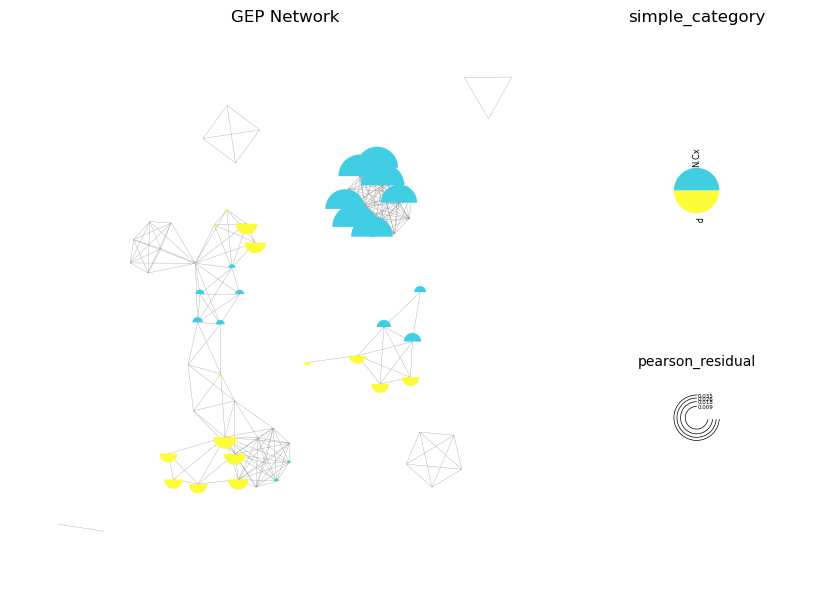

In [31]:
fig = cn.plot_gep_overrepresentation_network(snsmap, colors, subset_datasets="CPTAC", layer="simple_category")
fig.savefig("cptac_overrepresentation.pdf")

# GEP Communities

2023-03-07 11:30:05,724 [INFO] Choosing distinct community colors


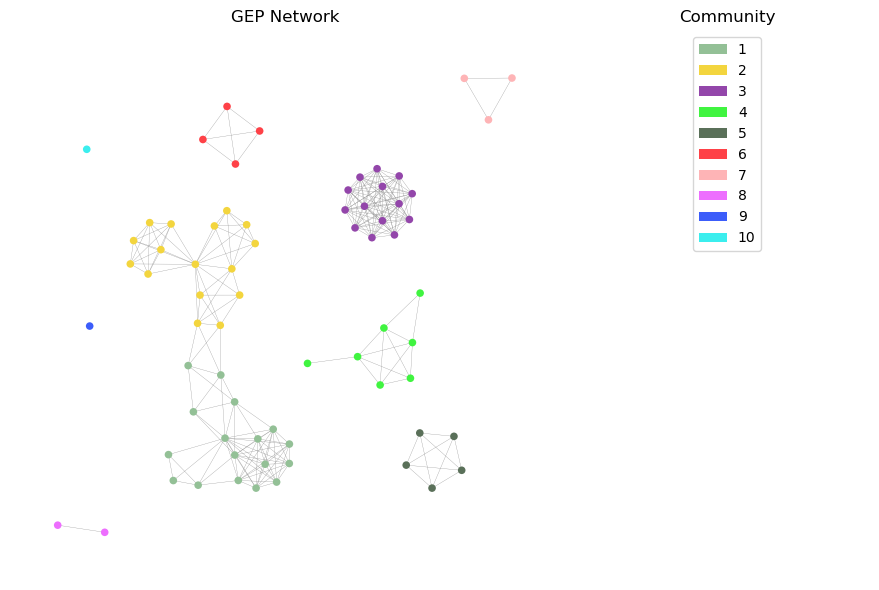

In [32]:
colors.add_missing_community_colors(snsmap)
fig = cn.plot_gep_network_communities(snsmap, colors)

Plot a summary showing the size of each community (node size) and number of edges connecting communities (edge width).

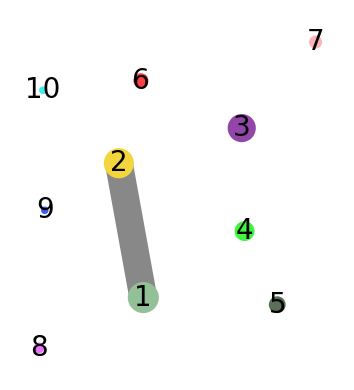

In [33]:
fig = cn.plot_community_network_summary(snsmap, colors)

Plot summarized GEP usage heatmap summarized by Community

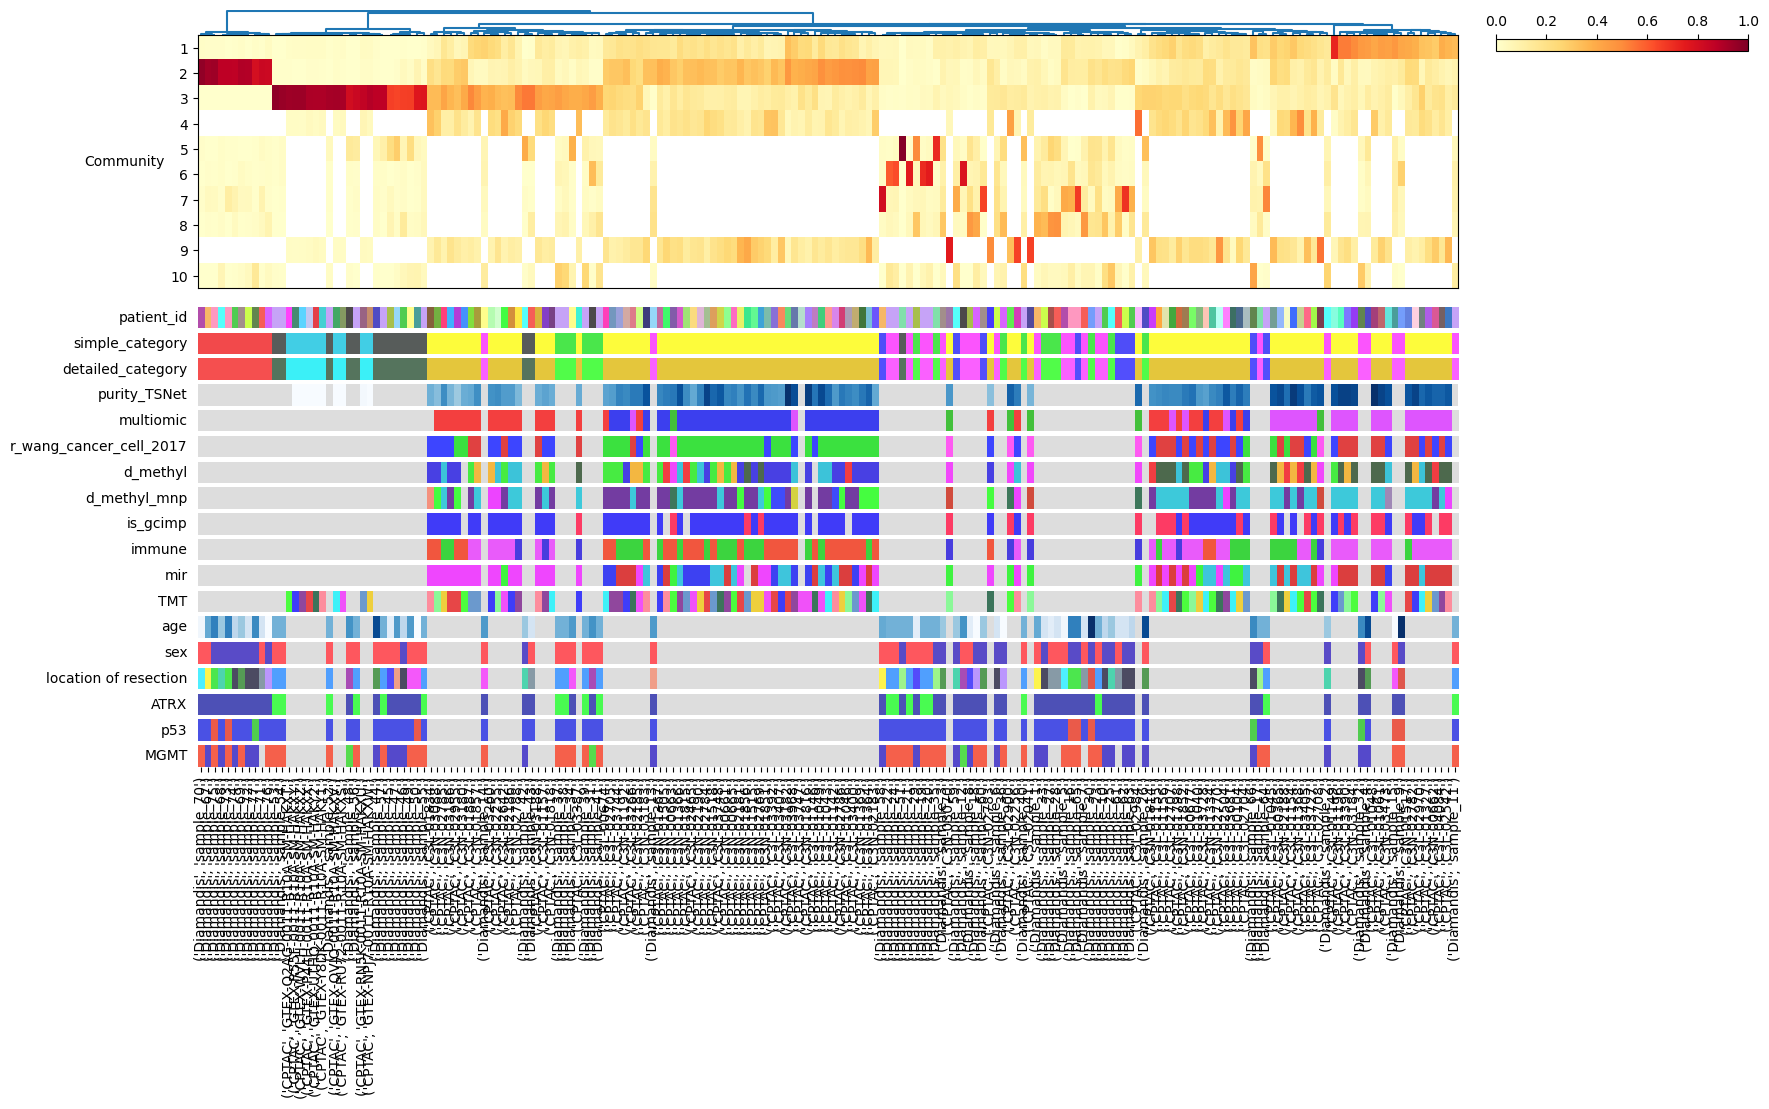

In [34]:
fig = cn.plots.plot_community_usage_heatmap(snsmap, colors)
# fig_legend = colors.plot_metadata_colors_legend()

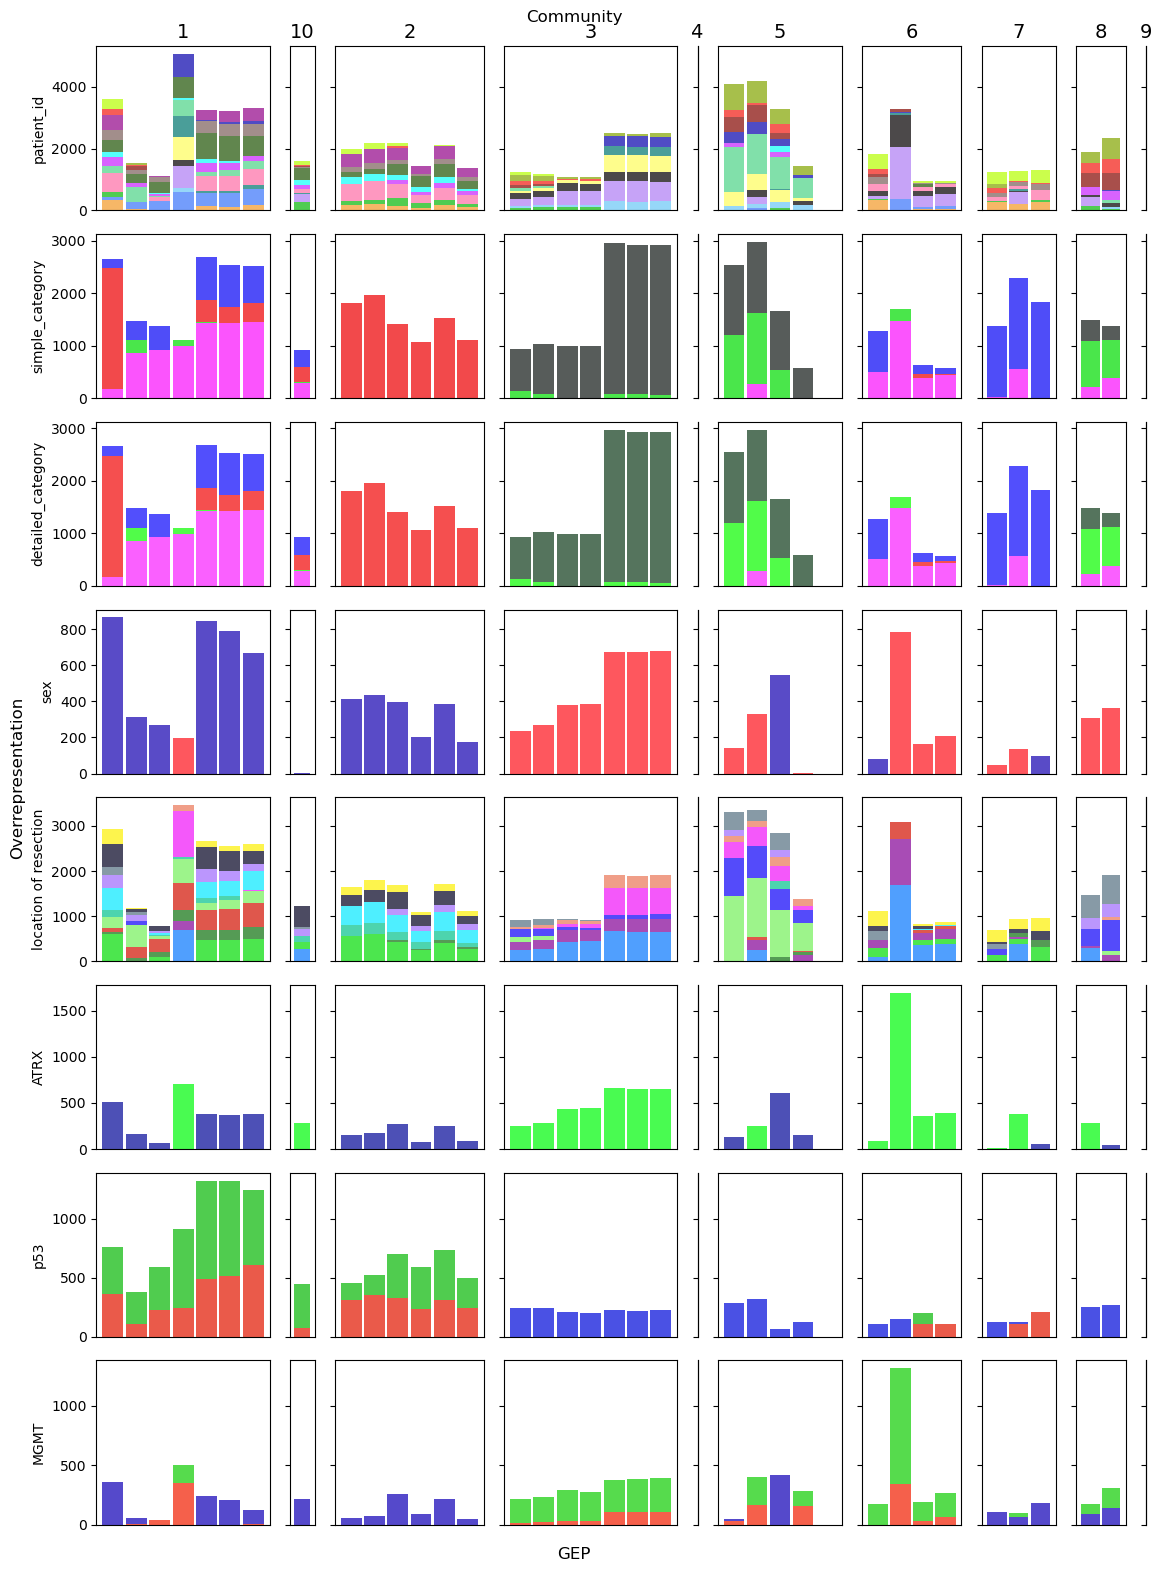

In [35]:
fig = cn.plot_overrepresentation_geps_bar(snsmap, colors, dataset_name="Diamandis")

# Community-level summary of overrepresentation